# Importing the Libraries

In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

# Generating Time Series Data

In [0]:
class TimeSeriesData():
  
    def __init__(self, num_points, x_min, x_max):
        self.num_points = num_points
        self.x_min = x_min
        self.x_max = x_max
        self.resolution = (x_max - x_min)/num_points
        self.x_data = np.linspace(x_min, x_max, num_points)
        self.y_true = np.sin(self.x_data)
    
    def ret_true(self, x_series):
        return np.sin(x_series)
  
    def next_batch(self, batch_size, steps, return_batch_ts=False):
        rand_start = np.random.rand(batch_size, 1)
        ts_start = rand_start*(self.x_max - self.x_min - (steps*self.resolution))
        batch_ts = ts_start + np.arange(0.0, steps+1)*self.resolution
        y_batch = np.sin(batch_ts)
    
        if return_batch_ts:
            return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1), batch_ts
        else:
            return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1)

# Instantiating a data object

In [0]:
ts_data = TimeSeriesData(250, 0, 10)

# Sine Wave

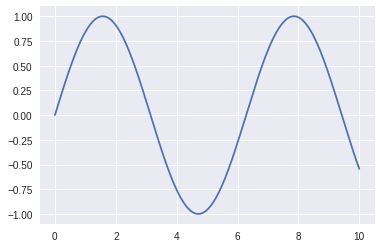

In [4]:
plt.plot(ts_data.x_data, ts_data.y_true)

## Defining time steps

In [0]:
num_time_steps = 30

In [0]:
y1, y2, ts = ts_data.next_batch(1, num_time_steps, True)

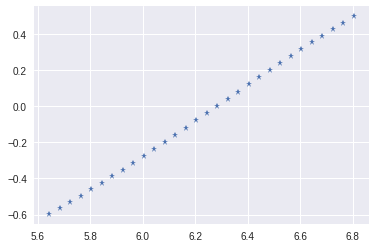

In [7]:
plt.plot(ts.flatten()[1:], y2.flatten(), '*')

# Plotting a training instance

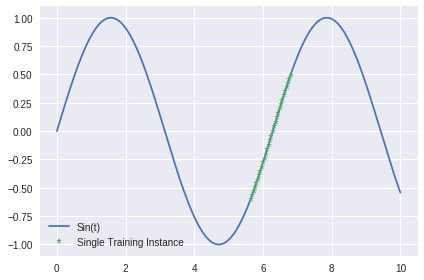

In [8]:
plt.plot(ts_data.x_data, ts_data.y_true, label='Sin(t)')
plt.plot(ts.flatten()[1:], y2.flatten(), '*', label='Single Training Instance')
plt.legend()
plt.tight_layout()

In [0]:
train_inst = np.linspace(5,5 + ts_data.resolution*(num_time_steps+1), num_time_steps+1)

# Plotting the training instance trend

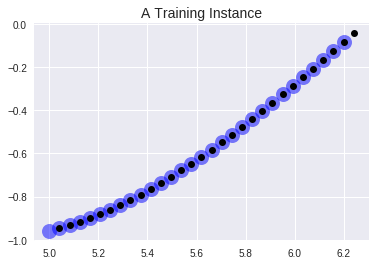

In [10]:
plt.title('A Training Instance', fontsize=14)
plt.plot(train_inst[:-1], ts_data.ret_true(train_inst[:-1]), 'bo', markersize=15, alpha=0.5, label='instance')
plt.plot(train_inst[1:], ts_data.ret_true(train_inst[1:]), "ko", markersize=7, label="target")

In [0]:
tf.reset_default_graph()

# Hyper-parameters

In [0]:
num_inputs = 1
num_neurons = 100
num_outputs = 1
learning_rate = 0.0001
num_train_iterations = 2000
batch_size = 1

# Placeholders

In [0]:
X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])

# The RNN Cell

In [14]:
cell = tf.contrib.rnn.OutputProjectionWrapper(tf.contrib.rnn.BasicRNNCell(num_units = num_neurons, activation = tf.nn.relu), output_size = num_outputs)

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.


# Storing the outputs and the state of our RNN Cell

In [0]:
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype = tf.float32)

# Loss Function and Optimization Technique

In [0]:
loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
train = optimizer.minimize(loss)

In [0]:
init = tf.global_variables_initializer()

In [0]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.75)

# Saving our model

In [0]:
saver = tf.train.Saver()

# Training our model

In [20]:
with tf.Session(config = tf.ConfigProto(gpu_options = gpu_options)) as sess:
    sess.run(init)
        for iteration in range(num_train_iterations):
            X_batch, y_batch = ts_data.next_batch(batch_size, num_time_steps)
            sess.run(train, feed_dict={X: X_batch, y: y_batch})
            if iteration%100 == 0:
                mse = loss.eval(feed_dict={X: X_batch, y:y_batch})
            print(iteration, '\tMSE:', mse)
        saver.save(sess, './rnn_time_series_model')

0 	MSE: 0.71348435
100 	MSE: 0.06019949
200 	MSE: 0.0041140695
300 	MSE: 0.042214144
400 	MSE: 0.0014438975
500 	MSE: 0.024364034
600 	MSE: 0.00025130465
700 	MSE: 0.01285013
800 	MSE: 0.01670179
900 	MSE: 0.011234803
1000 	MSE: 0.0132672805
1100 	MSE: 0.008344343
1200 	MSE: 0.01725607
1300 	MSE: 0.017493846
1400 	MSE: 0.008109601
1500 	MSE: 0.0056801583
1600 	MSE: 0.0026583502
1700 	MSE: 0.013006643
1800 	MSE: 0.0048239767
1900 	MSE: 0.0075397417


# Predicting the continuation

In [21]:
with tf.Session() as sess:
    saver.restore(sess, './rnn_time_series_model')
  
    X_new = np.sin(np.array(train_inst[:-1].reshape(-1, num_time_steps, num_inputs)))
    y_pred = sess.run(outputs, feed_dict={X:X_new})

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


# Predicting the value for T = T+1

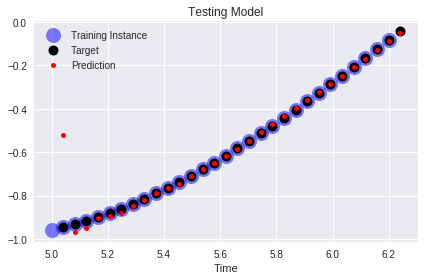

In [22]:
plt.title('Testing Model')
plt.plot(train_inst[:-1], np.sin(train_inst[:-1]), 'bo', markersize=15, alpha=0.5, label='Training Instance')
plt.plot(train_inst[1:], np.sin(train_inst[1:]), 'ko', markersize=10, label='Target')
plt.plot(train_inst[1:], y_pred[0,:,0], 'r.', markersize=10, label='Prediction')
plt.xlabel('Time')
plt.legend()
plt.tight_layout()

# Generating a Sequence

In [23]:
with tf.Session() as sess:
    saver.restore(sess, './rnn_time_series_model')
  
    zero_seq_seed = [0. for i in range(num_time_steps)]
    for iteration in range(len(ts_data.x_data) - num_time_steps):
        X_batch = np.array(zero_seq_seed[-num_time_steps:]).reshape(1, num_time_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        zero_seq_seed.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


# Plotting the generated sequence
Red Line indicates the zeros in the start of the sequence, not a sine wave but its close. Providing a real sine wave may help it to learn the sequence

Text(0,0.5,'Value')

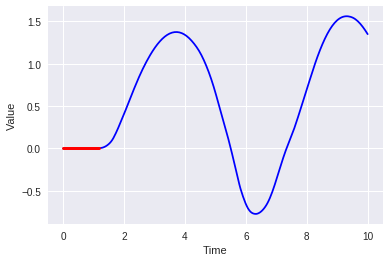

In [24]:
plt.plot(ts_data.x_data, zero_seq_seed, 'b-')
plt.plot(ts_data.x_data[:num_time_steps], zero_seq_seed[:num_time_steps], 'r', linewidth=3)
plt.xlabel('Time')
plt.ylabel('Value')

# Generating the Sine Wave Sequence
Seeding it with actual sine wave helps it learn the rest of the sequence

In [25]:
with tf.Session() as sess:
    saver.restore(sess, './rnn_time_series_model')
  
    training_instance = list(ts_data.y_true[:30])
    for iteration in range(len(training_instance) - num_time_steps):
        X_batch = np.array(training_instance[-num_time_steps:]).reshape(1, num_time_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X:X_batch})
        training_instance.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


# Plotting the generated Sine Wave

Text(0.5,0,'Time')

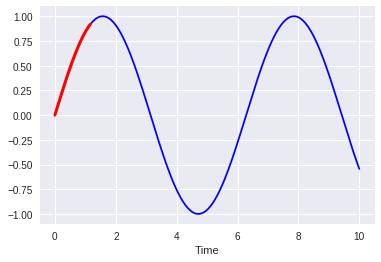

In [26]:
plt.plot(ts_data.x_data, ts_data.y_true, 'b-')
plt.plot(ts_data.x_data[:num_time_steps], training_instance[:num_time_steps], 'r-', linewidth=3)
plt.xlabel('Time')